### TODO list.

0. Avoid overfitting.
1. Explore ways of measuring an error.
2. It's not *R_{3} \* *R_{4}. Try to predict [x, y, 0], [0.5w] \in len_x \* len_y \* [-PI/2, PI/2].
3. Visualisation for errors distr.
4. Generally - explore errors.
5. Spartial presentation for true (p, q) vs. predicted (p, q) pairs.

## Imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
np.random.seed(1540)

import time
from datetime import timedelta
import os

import inception

import data_manipulation as dm
from cache import cache

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Preparing pre-trained NN and data.

In [2]:
data_pos = dm.data_pos
data_q = dm.data_q

In [3]:
# Loading inception NN.
file_path_cache_transfer_values = os.path.join(dm.DATA_GENERATED_PATH, 'transfer_values.pkl')

if not os.path.exists(file_path_cache_transfer_values):
    data_img = dm.getImgData()
else:
    data_img = None
    
inception.data_dir = 'inception/'
inception.maybe_download()
model = inception.Inception()

# Calculating ouptups of -2-th layer of pre-trained NN for each image.
from inception import transfer_values_cache

transfer_values = transfer_values_cache(cache_path=file_path_cache_transfer_values, 
                                        images=data_img, 
                                        model=model)

Data has apparently already been downloaded and unpacked.
- Data loaded from cache-file: data_generated\transfer_values.pkl


In [4]:
# Preparing indexes for train and test data subsets.
train_test_split = 0.8

data_len = len(transfer_values)
train_len = int(train_test_split * data_len)
test_len = data_len - train_len

idx_train = np.array(sorted(np.random.choice(data_len, train_len, replace=False)))
idx_test = np.array([idx for idx in np.arange(data_len) if idx not in idx_train])

In [5]:
transfer_values_train, pos_train, q_train = transfer_values[idx_train], data_pos[idx_train], data_q[idx_train]
transfer_values_test, pos_test, q_test = transfer_values[idx_test], data_pos[idx_test], data_q[idx_test]

print(idx_train.shape, transfer_values_train.shape, pos_train.shape, q_train.shape)
print(idx_test.shape, transfer_values_test.shape, pos_test.shape, q_test.shape)

(800,) (800, 2048) (800, 3) (800, 4)
(200,) (200, 2048) (200, 3) (200, 4)


In [6]:
# Plotting image data.
def plot_transfer_values(i):    
    file_name = dm.data_file_names[i, 0]
    img = dm.readImg(file_name)
    pos, q = data_pos[i], data_q[i]
    
    alpha = 2 * np.arcsin(-q[3])
    alpha_deg = alpha * 360 / np.pi
    
    plt.imshow(img, interpolation='nearest')
    title_img = 'pos: {0}\nq: {1}\nalpha: {2:>6.4f}\nalpha_deg: {3:>6.4f}\nfile_name: {4}'
    title_img = title_img.format(str(pos), str(q), alpha, alpha_deg, file_name)
    plt.title(title_img)#'pos: %s\nq: %s\nalpha: %s, alpha_deg: {%s:8.6}' % (pos, q, alpha, alpha_deg))
    plt.show()
    
    # Transform the transfer-values into an image.
    img = transfer_values[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.title('Transfer-values for the image using Inception model:')
    plt.show()

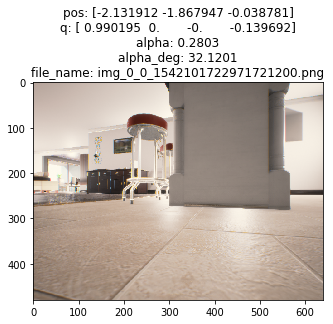

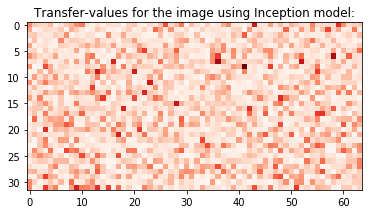

In [7]:
plot_transfer_values(i=256)

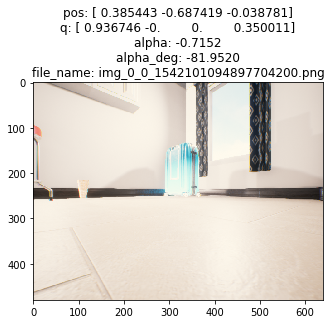

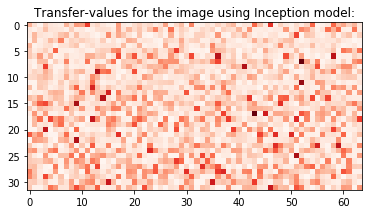

In [8]:
plot_transfer_values(i=193)

## Describing new NN with TensorFlow.

In [9]:
# Coeff for weighting between pos an q losses.
beta = tf.Variable(300.0, name='beta')

# Input for 2048-sized transfer val vectors.
transfer_len = model.transfer_len
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')

# Inputs for true pos and q values.
y_pos_true = tf.placeholder(tf.float32, shape=[None, 3], name='pos_true')
y_q_true = tf.placeholder(tf.float32, shape=[None, 4], name='q_true')

In [10]:
# Designing tf-graph.
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

# 1-st layer of fc1_size neurons.
fc1_in_size = x.shape[1].value
fc1_size = 16

W_fc1 = weight_variable([fc1_in_size, fc1_size])
b_fc1 = bias_variable([fc1_size])
h_fc1 = tf.nn.sigmoid(tf.matmul(x, W_fc1) + b_fc1, name='layer_fc1')

# ???? Dropout. # LATER...
# h_fc1 = tf.nn.dropout(h_fc1, 0.9, name='layer_fc1_dropout')

# 2-nd layer (part for prediction of pos value).
W_fc2_pos = weight_variable([fc1_size, 3])
b_fc2_pos = bias_variable([3])
y_pos_pred = tf.add(tf.matmul(h_fc1, W_fc2_pos), b_fc2_pos, name='y_pos_pred')

# 2-nd layer (part for prediction of q value).
W_fc2_q = weight_variable([fc1_size, 4])
b_fc2_q = bias_variable([4])
y_q_pred = tf.add(tf.matmul(h_fc1, W_fc2_q), b_fc2_q, name='y_q_pred')

# calculating losses
losses_pos = tf.reduce_sum((y_pos_true - y_pos_pred)**2, reduction_indices=[1], name='losses_pos')

y_q_true_norm = (tf.reduce_sum(y_q_true**2, reduction_indices=[1], keepdims=True))**0.5
y_q_true_normalized = tf.divide(y_q_true, y_q_true_norm, name='y_q_true_normalized')
losses_q = tf.reduce_sum((y_q_true_normalized - y_q_pred)**2, reduction_indices=[1], name='losses_q')

losses = tf.add(losses_pos, beta*losses_q, name='losses')

loss_pos = tf.reduce_mean(losses_pos, name='loss_pos')
loss_q = tf.reduce_mean(losses_q, name='loss_q')
loss = tf.reduce_mean(losses, name='loss')

In [11]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', 
                          trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

## Training NN.

In [12]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [13]:
train_batch_size = 64

In [14]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    x_batch = transfer_values_train[idx]
    y_pos_batch = pos_train[idx]
    y_q_batch = q_train[idx]

    return x_batch, y_pos_batch, y_q_batch

def fd_train_all(idx=np.arange(len(transfer_values_test))): # ALL TRAIN SAMPLES IN ONE BATCH
    x_batch = transfer_values_train[idx]
    y_pos_batch = pos_train[idx]
    y_q_batch = q_train[idx]
    
    feed_dict = {x: x_batch, 
                       y_pos_true: y_pos_batch, 
                       y_q_true: y_q_batch}

    return feed_dict

def fd_test_all(idx=np.arange(len(transfer_values_test))): # ALL TEST SAMPLES IN ONE BATCH
    x_batch = transfer_values_test[idx]
    y_pos_batch = pos_test[idx]
    y_q_batch = q_test[idx]

    feed_dict = {x: x_batch, 
                 y_pos_true: y_pos_batch, 
                 y_q_true: y_q_batch}
    
    return feed_dict

In [15]:
feed_dict_train_all = fd_train_all()
feed_dict_test_all = fd_test_all()

In [16]:
def optimize(num_iterations):
    train_history = []
    test_history = []
    
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        x_batch, y_pos_true_batch, y_q_true_batch = random_batch()
        
        feed_dict_train = {x: x_batch, 
                           y_pos_true: y_pos_true_batch, 
                           y_q_true: y_q_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            batch_loss, batch_loss_pos, batch_loss_q = session.run([loss, loss_pos, loss_q], feed_dict=feed_dict_train)
            train_loss, train_loss_pos, train_loss_q = session.run([loss, loss_pos, loss_q], feed_dict=feed_dict_train_all)
            test_loss, test_loss_pos, test_loss_q = session.run([loss, loss_pos, loss_q], feed_dict=feed_dict_test_all)
    
            msg = "Global Step: {0:>6}\nBatch losses - loss: {1:>6.4f}, loss_pos: {2:>6.4f}, loss_q: {3:>6.4f}"
            print(msg.format(i_global, batch_loss, batch_loss_pos, batch_loss_q))
            
            msg_train = "Train losses - loss: {1:>6.4f}, loss_pos: {2:>6.4f}, loss_q: {3:>6.4f}"
            print(msg_train.format(i_global, train_loss, train_loss_pos, train_loss_q))
            
            msg_test = "Test losses - loss: {1:>6.4f}, loss_pos: {2:>6.4f}, loss_q: {3:>6.4f}\n"
            print(msg_test.format(i_global, test_loss, test_loss_pos, test_loss_q))
            
            train_history.append([i_global, train_loss, train_loss_pos, train_loss_q])
            test_history.append([i_global, test_loss, test_loss_pos, test_loss_q])
         
    train_history = np.array(train_history)
    test_history = np.array(test_history)
        

    end_time = time.time()
    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    return(train_history, test_history)

In [17]:
train_history, test_history = optimize(num_iterations=64000)

Global Step:   1000
Batch losses - loss: 99.7295, loss_pos: 3.4179, loss_q: 0.3211
Train losses - loss: 95.1087, loss_pos: 4.0837, loss_q: 0.3035
Test losses - loss: 109.8312, loss_pos: 3.8230, loss_q: 0.3534

Global Step:   2000
Batch losses - loss: 26.0458, loss_pos: 3.7745, loss_q: 0.0743
Train losses - loss: 35.6831, loss_pos: 4.1460, loss_q: 0.1052
Test losses - loss: 45.4187, loss_pos: 3.7589, loss_q: 0.1389

Global Step:   3000
Batch losses - loss: 21.9136, loss_pos: 3.7888, loss_q: 0.0604
Train losses - loss: 22.7342, loss_pos: 4.1467, loss_q: 0.0620
Test losses - loss: 34.0313, loss_pos: 3.7519, loss_q: 0.1010

Global Step:   4000
Batch losses - loss: 10.3036, loss_pos: 4.5852, loss_q: 0.0191
Train losses - loss: 16.8815, loss_pos: 4.1396, loss_q: 0.0425
Test losses - loss: 30.7567, loss_pos: 3.7438, loss_q: 0.0901

Global Step:   5000
Batch losses - loss: 10.1878, loss_pos: 4.0616, loss_q: 0.0204
Train losses - loss: 12.5998, loss_pos: 4.1301, loss_q: 0.0283
Test losses - los

Global Step:  41000
Batch losses - loss: 0.0239, loss_pos: 0.0226, loss_q: 0.0000
Train losses - loss: 0.0270, loss_pos: 0.0254, loss_q: 0.0000
Test losses - loss: 28.1898, loss_pos: 0.5003, loss_q: 0.0931

Global Step:  42000
Batch losses - loss: 0.0333, loss_pos: 0.0314, loss_q: 0.0000
Train losses - loss: 0.0247, loss_pos: 0.0229, loss_q: 0.0000
Test losses - loss: 28.2182, loss_pos: 0.5016, loss_q: 0.0932

Global Step:  43000
Batch losses - loss: 0.0229, loss_pos: 0.0213, loss_q: 0.0000
Train losses - loss: 0.0219, loss_pos: 0.0205, loss_q: 0.0000
Test losses - loss: 28.2431, loss_pos: 0.5042, loss_q: 0.0933

Global Step:  44000
Batch losses - loss: 0.0192, loss_pos: 0.0179, loss_q: 0.0000
Train losses - loss: 0.0199, loss_pos: 0.0182, loss_q: 0.0000
Test losses - loss: 28.2439, loss_pos: 0.5053, loss_q: 0.0933

Global Step:  45000
Batch losses - loss: 0.0207, loss_pos: 0.0198, loss_q: 0.0000
Train losses - loss: 0.0176, loss_pos: 0.0165, loss_q: 0.0000
Test losses - loss: 28.2625,

## Results.

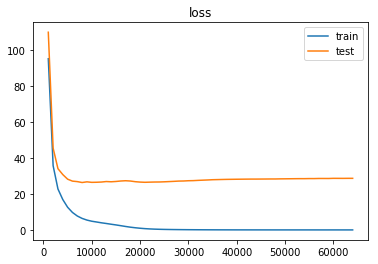

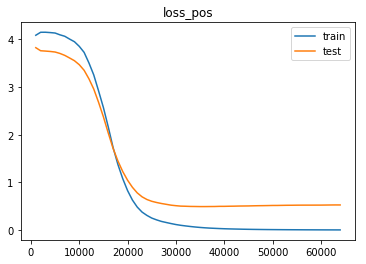

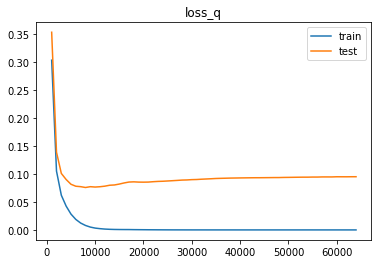

In [18]:
plt.plot(train_history[:, 0], train_history[:, 1], label='train')
plt.plot(test_history[:, 0], test_history[:, 1], label='test')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(train_history[:, 0], train_history[:, 2], label='train')
plt.plot(test_history[:, 0], test_history[:, 2], label='test')
plt.title('loss_pos')
plt.legend()
plt.show()

plt.plot(train_history[:, 0], train_history[:, 3], label='train')
plt.plot(test_history[:, 0], test_history[:, 3], label='test')
plt.title('loss_q')
plt.legend()
plt.show()

## More results. Attempts to understand data.
!!!!    Still under construction. Need more time.    !!!!

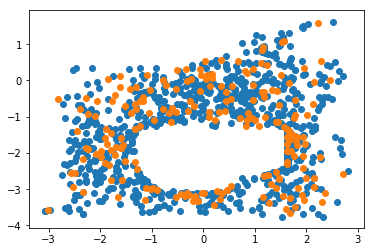

In [19]:
plt.scatter(pos_train[:,0], pos_train[:,1])
plt.scatter(pos_test[:,0], pos_test[:,1])
plt.show()

In [20]:
                #### !!!! CLEAN THIS !!!! ####

def quat_len(q):
    return((np.sum(q**2))**0.5)

q_s = q_train

# cosw_s = q_s[:,0]

# alpha_s = 2 * np.arccos(q_s[:,0])

cos_s = q_s[:,0]
sin_s = (1 - cos_s**2)**0.5

# cos_s.shape, sin_s.shape
vec_s = q_s[:,1:] / np.expand_dims(sin_s, axis=1)

# for i in range(4):
#     print(cos_s[i], sin_s[i], vec_s[i], q_s[i])
    
set(q_s[:,1]), set(q_s[:,2])
# len(set(q_s[:,1]))

tst = np.array([[cos_s[i], 0.0, 0.0, sin_s[i]] for i in range(len(sin_s))])


# tst.shape, q_s.shape, np.min(np.abs(tst - q_s)), np.max(np.abs(tst[:,:3] - q_s[:,:3]))

# for i in range(len(q_s)):
#     if np.abs(tst[i,3] - q_s[i,3]) > 0.5:
#         print(i, q_s[i], tst[i])

# for i in range(4):
#     print(np.min(q_s[:, i]), np.max(q_s[:, i]))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


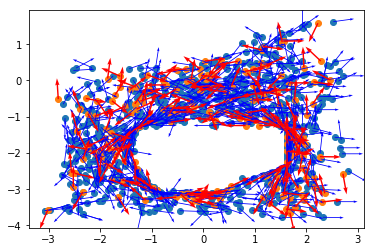

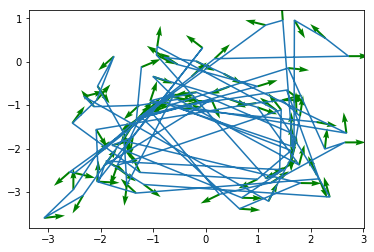

In [21]:
q_s = data_q
cos_s = data_q[:, 0]
sin_s = data_q[:, 3]
alpha_s = 2 * np.arcsin(sin_s)

alpha_rt = (np.pi / 2) * (0)
q_vec_x_s = np.cos(alpha_s + alpha_rt)
q_vec_y_s = np.sin(alpha_s + alpha_rt)

q_vec_x_s_train = q_vec_x_s[idx_train]

plt.scatter(pos_train[:,0], pos_train[:,1])
plt.scatter(pos_test[:,0], pos_test[:,1])

# origin = [0], [0] # origin point

# plt.quiver(pos_train[:,0], pos_train[:,1], q_vec_x_s[idx_train], q_vec_y_s[idx_train], color=['r','b','g'], scale=21)
plt.quiver(pos_train[:,0], pos_train[:,1], q_vec_x_s[idx_train], q_vec_y_s[idx_train], color=['b'], scale=16)
plt.quiver(pos_test[:,0], pos_test[:,1], q_vec_x_s[idx_test], q_vec_y_s[idx_test], color=['r'], scale=16)
plt.show()


# idx_0 = np.arange(1000)
idx_0 = np.arange(300, 400)
# plt.scatter(data_pos[idx_0,0], data_pos[idx_0,1])
plt.plot(data_pos[idx_0,0], data_pos[idx_0,1])
plt.quiver(data_pos[idx_0,0], data_pos[idx_0,1], q_vec_x_s[idx_0], q_vec_y_s[idx_0], color=['g'], scale=16)
plt.show()

# len(set(pos_test[:,2]))

In [22]:
model.close()
session.close()